In [8]:
import pandas as pd
from pandasql import sqldf 
import numpy as np
import matplotlib.pyplot as plt

from itertools import product

In [9]:
sql = lambda q: sqldf(q, globals())
df = pd.read_csv("athlete_events.csv")


### Clean

In [10]:
def clean(bbd:str,columns:list):
    qry = sql('''
    SELECT
    {1}
    FROM {0}
    '''.format(bbd,str(columns)[1:-1].replace("'" , "")))
    return qry

in this report, we going to explain how can to see  discrimination of gender in sports in the previous years,
To beginning, we going to exclude from the analysis the names of participants as this will be not relevant for the report, also going to make cleaning to different columns that have inconsistencies in their values, for example, the column Team has the same teams with different names.

In [11]:
columns = 'ID','Sex','Age','Height','Weight','Team','Year','Season','City','Sport'
newdf = clean('df',columns)
newdf = newdf.dropna(subset=['Age','Height','Weight'])
newdf.Team= newdf.Team.str.replace('[\d+\W]','', regex=True)

we Going to make a function that separates genders in two data frames, it is to make an analysis without bias for gender. 

In [12]:
def sex(bbd, columns:list, sex:str):
    qry = sql('''
    SELECT
    {1}
    FROM {0}
    WHERE Sex = "{2}"
    '''.format(bbd,str(columns)[1:-1].replace("'" , ""), sex))
    return qry

In [13]:
Male = sex('newdf',columns,'M')
Female = sex('newdf', columns, 'F')
print(' Shape Male DataFrame {} \n Shape Female DataFrame {}'.format(Male.shape, Female.shape))

 Shape Male DataFrame (139454, 10) 
 Shape Female DataFrame (66711, 10)


In this step we did a function to count the frequency of values in different column, in the next step is possible to see, a table with frequentist of age by gender.


In [14]:
def Count(bbd:str, column:str):
    qry= sql('''
    SELECT
    {1},
    COUNT({1}) as count
    FROM {0}
    GROUP BY {1}
    '''.format(bbd,column))
    return qry

In [15]:
countageM = Count('Male','Age')
countageF = Count('Female','Age')
count = pd.concat([countageM,countageF],keys=['Male','Female']).droplevel(level=1)
count.sort_values(by='Age', ascending=False)

,Age,count
Male,71.0,1
Male,70.0,2
Female,69.0,2
Male,68.0,1
Male,67.0,2
...,...,...
Female,13.0,133
Male,13.0,28
Female,12.0,24
Male,12.0,3


#### Distribution of age by gender.

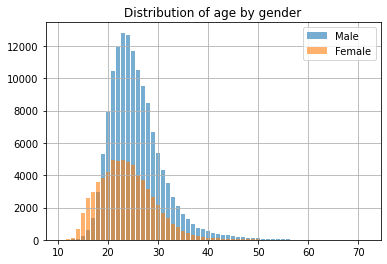

In [16]:
fig, ax = plt.subplots()
M = ax.bar(countageM['Age'],countageM['count'], label='Male', alpha=0.6)
F = ax.bar(countageF['Age'], countageF['count'], label='Female', alpha=0.6)
ax.legend()
plt.title('Distribution of age by gender')
plt.grid()
plt.show()

#### Stast 
How is the minimum age of participation in Male, what is average, how will be max? this is the same for Women, those questions will be answered in the next block with this function. 

In [17]:
def stast(bbd:str, column, sex:str):
    qry=sql('''
    SELECT
    min({1}) as min,
    ROUND(avg({1}),2) as avg,
    max({1}) as max
    FROM {0}
    '''.format(bbd, column,sex))
    return qry

In [18]:
stastM = stast('countageM','Age','Male')
stastF = stast('countageF', 'Age','Female')
summary = pd.concat([stastM,stastF],keys=['Male','Female']).droplevel(level=1)
summary

,min,avg,max
Male,12.0,41.03,71.0
Female,11.0,38.22,69.0


In [19]:
def stastplot(df:pd.DataFrame):
    
    assert type(df) == pd.DataFrame, "First parameter should be a DataFrame"
    
    x = np.arange(len(df.iloc[0].index))
    width = 0.2
    for i in range(0,len(summary),1):
        if i <= 0:
            plt.bar(x , df.iloc[i], width=0.2, label='Male',alpha=0.6)
        else:
            plt.bar(x + (width*1), df.iloc[i],width=0.2, label='Female',alpha=0.6)
    plt.xticks(x, ['min','avg','max'], horizontalalignment="left")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    

#### Stastplot

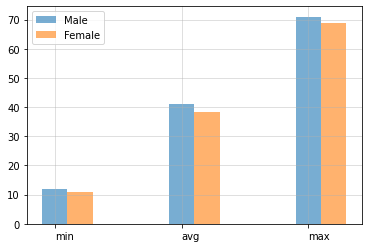

In [20]:
stastplot(summary)

#### Count Sex by Team
In this step we want to answer the question about what are the teams with more and fewer participants by gender, but for this, we can't simply compare columns, we going to create an index that will be a relation between quantity men vs women, this way we could know what are countries whit the same relative participation (values near to 0, or unequal participation (values most to 1)

In [21]:
def team(bdd, groupby:str, orderby:str):
    qry = sql('''
    SELECT
    Team,
    Count({count}) as count
    FROM {df}
    Group by {group}
    Order by {order} desc
    '''.format(count = 'ID', df=bdd, group=groupby,order=orderby))
    return qry


In [22]:
M = team('Male','Team','count')
F = team('Female','Team','count')

In [23]:
def joinMF():
    qry = sql('''
    -- METRICS
    SELECT
    Team,
    Mcount,
    Fcount,
    (Mcount - Fcount) as diference,
    ROUND(CAST(Mcount as float) / CAST(Fcount as float),2)  as div
    FROM
    (-- FILL VALUE WITH 0 WHERE FCOUNT IS NAN
    SELECT
    Team,
    Mcount,
    COALESCE(Fcount,0) as Fcount
    FROM 
    ( -- JOIN TABLE M,F
    SELECT
    M.Team,
    M.count as Mcount,
    F.count as Fcount
    FROM M 
    LEFT JOIN F
    ON M.Team = F.Team))
    ''')
    return qry



In [24]:
joinMF = joinMF()
joinMF = joinMF[~joinMF['div'].isnull()]

In [25]:
joinMF50 = joinMF.sort_values(by='div', ascending=False).head(50)

Here we can see that the countries with the higher index or unequal participation by gender are countries with association cultures where women have low participation in activities.

### Plot relation between men vs women

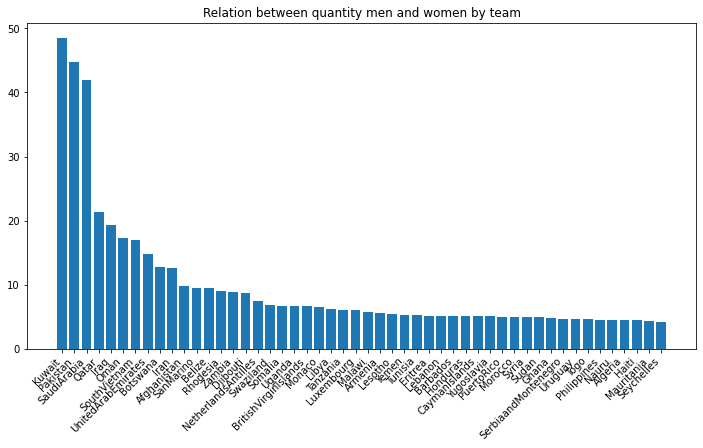

In [26]:
plt.figure(figsize=(12,6))
plt.bar(joinMF50['Team'],joinMF50['div'])
plt.xticks(rotation=45,horizontalalignment="right")
plt.title("Relation between quantity men and women by team")
plt.show()

How the participation has affected by year? is there countries with improvements in its political for partipation inclusive of all sex?


In [27]:
teamByYear = pd.DataFrame(Male.groupby(['Team','Year']).count()['ID'])

In [28]:
def teambyyear(df:str):    
    qry = sql('''
    SELECT
    Team,
    Year,
    Count('ID') as count{0}
    FROM {0}
    Group by Team,Year
    '''.format(df))
    return qry


In [29]:
M = teambyyear('Male')
F = teambyyear('Female')

In [30]:
testM = M[M['Team'] == 'Iran'] 
testF = F[F['Team'] == 'Iran']


In [31]:
def country(country:str, team='Team'):
    Male =M[M[team] ==country]
    Fem = F[F[team] == country]
    merge = Male.merge(Fem, on='Year', how='left')
    merge = merge.fillna(0)
    merge = merge.drop(['Team_y'],axis=1)
    merge.columns = ['Country','Year','Male','Female']
    return merge

In [32]:
def teambycountry(country):
    qry=sql('''
    SELECT
    Team,
    Year,
    Male,
    COALESCE(Female,0) as Female
    FROM (
    -- SELECT COLUMNS
    SELECT
    M.Team,
    M.Year,
    M.countMale as Male,
    F.countFemale as Female
    FROM
    -- JOIN M with F
    (SELECT
    *
    FROM M
    WHERE Team = "{0}") as M
    LEFT  JOIN (
    -- DATASET FEMALE
    SELECT
    *
    FROM F
    WHERE Team ="{0}") as F
    ON M.Year = F.Year)
    '''.format(country))
    return qry

In [33]:
def barplot(df):
    country = teambycountry(df)
    plt.figure(figsize=(12,6))
    width = 2
    plt.bar(country.Year, country['Male'], width=width)
    plt.bar(country.Year, country['Female'],width=width)
    plt.title('{}'.format(df))
    plt.show

In [34]:
countries = ['Kuwait','Pakistan','SaudiArabia','Qatar','Iraq','Oman','SouthVietnam','UnitedArabEmirates']

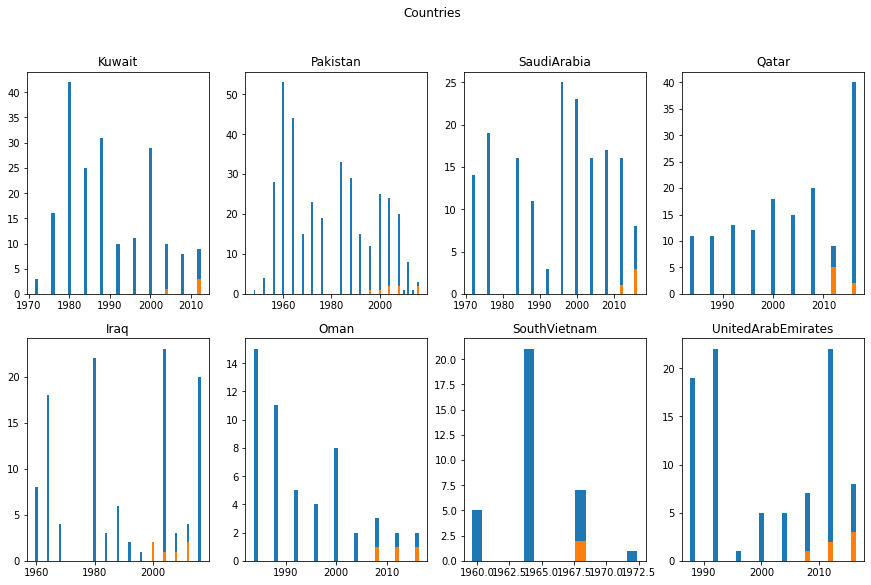

In [35]:
fig, ax = plt.subplots(2,4, figsize=(15,9))
fig.suptitle('Countries')
for i,j in zip(countries,list(product(range(0,2,1),range(0,4,1)))):
    country= teambycountry(i)
    ax[j].bar(country.Year, country['Male'])
    ax[j].bar(country.Year, country['Female'])
    ax[j].set_title('{}'.format(i))
   


In the previous graph is possible to see that any countries in particular currently yet there is discrimination in the participation of women in sports, with gaps very  pronounced

In [36]:
joinMF50 = joinMF.sort_values(by='div', ascending=True).head(50)
joinMF50.head(10)

,Team,Mcount,Fcount,diference,div
276,Kosovo,3,5,-2,0.60
19,China,2199,2679,-480,0.82
203,Palau,11,13,-2,0.85
220,MarshallIslands,6,7,-1,0.86
216,CapeVerde,8,9,-1,0.89
109,Angola,122,123,-1,0.99
244,TimorLeste,3,3,0,1.00
435,Twinkle,1,1,0,1.00
198,SaintLucia,14,13,1,1.08
126,Vietnam,77,69,8,1.12


In [37]:
countries = ['China','Palau','MarshallIslands','CapeVerde','Angola','TimorLeste','SaintLucia','Vietnam']

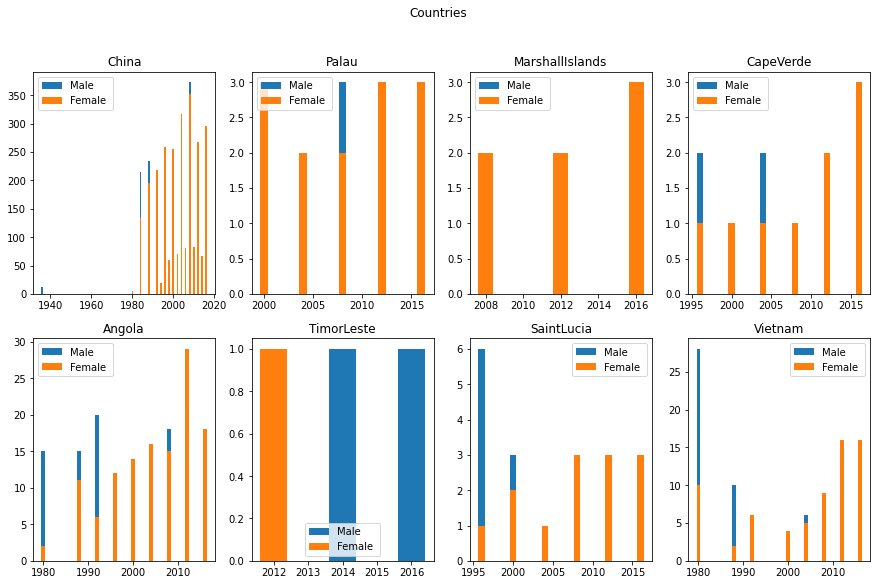

In [38]:
fig, ax = plt.subplots(2,4, figsize=(15,9))
fig.suptitle('Countries')
for i,j in zip(countries,list(product(range(0,2,1),range(0,4,1)))):
    country= teambycountry(i)
    ax[j].bar(country.Year, country['Male'], label='Male')
    ax[j].bar(country.Year, country['Female'],label='Female ')
    ax[j].set_title('{}'.format(i))
    ax[j].legend()
   

on the other hand, also there is countries where the participation of women is more that men.

### CORRELATION 

In [39]:
def encoding():
    df = sql('''
    SELECT
    Age,
    Height,
    Weight,
    Year,
    Season,
    City,
    Sport,
    CASE
        WHEN Sex='M' THEN 1
        ELSE 0
        END AS Gender,
    CASE
        WHEN Season='Summer' THEN 1
        ELSE 0
        END AS Seasonn
    FROM newdf''')
    return df
newdf=encoding()

Now we going to show the correlation between columns and to see if is possible to find any relation between columns and gender, I mean,is the year participation a deteminant for inclusion of women in sport? 


In [40]:
from sklearn.preprocessing import OrdinalEncoder
column = newdf[['City','Sport']]
enc =  OrdinalEncoder()
epa = enc.fit_transform(column)
newdf = newdf.drop(column,axis=1).merge(pd.DataFrame(epa, columns=['City','Sport']), on=newdf.index)
newdf.head()

,key_0,Age,Height,Weight,Year,Season,Gender,Seasonn,City,Sport
0,0,24.0,180.0,80.0,1992,Summer,1,1,5.0,6.0
1,1,23.0,170.0,60.0,2012,Summer,1,1,17.0,26.0
2,2,21.0,185.0,82.0,1988,Winter,0,0,8.0,43.0
3,3,21.0,185.0,82.0,1988,Winter,0,0,8.0,43.0
4,4,25.0,185.0,82.0,1992,Winter,0,0,0.0,43.0


In [41]:
import seaborn as sns
def corr(df):
    corr = df.drop(['key_0','Season'],axis=1).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix')
    plt.show()

In the next graph is possible to see that if there is a mild relation between year and its influence on Gender, but this is not sufficient to explain discrimination for women in sports.

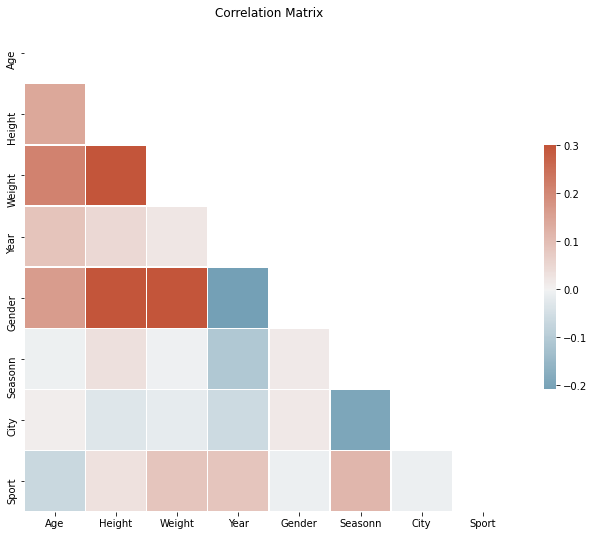

In [42]:
corr(newdf)